In [1]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from sklearn.metrics import r2_score
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches


import matplotlib as mpl
import polars as pl

def annotate_metrics(x, y, ax=None, **kwargs):
    """
    Annotate MAE, RMSE, and R² directly on the graph as red text.
    """
    ax = ax or plt.gca()
    mae = np.mean(np.abs(x - y))
    rmse = np.sqrt(np.mean((x - y) ** 2))
    r2 = r2_score(x, y)
    ax.text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}',
            transform=ax.transAxes, fontsize=15, color='red', ha='left', va='top')

def density_hist2d(x, y, ax=None, bins=1000, range=None, **kwargs):
    """
    Create a 2D histogram colored by log(count) to show density.
    """
    ax = ax or plt.gca()
    
    h = ax.hist2d(x, y, bins=bins, range=range, norm=LogNorm(), cmap='viridis')
    
    # h is a tuple: (counts, xedges, yedges, image)
    # We return the image so we can potentially create a global colorbar outside.
    return h

def density_scatter_plot(x, y,ax=None, **kwargs):
    """
    :param x: data positions on the x axis
    :param y: data positions on the y axis
    :return: matplotlib.collections.PathCollection object
    """
    # Kernel Density Estimate (KDE)
    ax = ax or plt.gca()

    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)

    # create array with colors for each data point
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba(kde)

    # override original color argument
    kwargs['color'] = colors

    return plt.scatter(x, y, **kwargs)

def density_scatter(x, y, ax=None, bins=100, range=None, **kwargs):
    ax = ax or plt.gca()
    # Remove any existing 'color' or 'c' from kwargs to avoid conflicts
    kwargs.pop('color', None)
    kwargs.pop('c', None)
    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range)
    
    # Find bin indices for each point
    x_bin = np.searchsorted(xedges, x, side='right') - 1
    y_bin = np.searchsorted(yedges, y, side='right') - 1
    in_range = (x_bin >= 0) & (x_bin < len(xedges)-1) & (y_bin >= 0) & (y_bin < len(yedges)-1)
    x_in = x[in_range]
    y_in = y[in_range]
    x_bin = x_bin[in_range]
    y_bin = y_bin[in_range]
    
    point_density = counts[x_bin, y_bin]
    log_density = np.log10(point_density + 1)

    norm = Normalize(vmin=log_density.min(), vmax=log_density.max())
    cmap = cm.get_cmap('viridis')
    colors = cmap(norm(log_density))

    scatter = ax.scatter(x_in, y_in, c=colors, **kwargs)
    
    # Store the norm and cmap as attributes on the scatter for later retrieval
    scatter.norm = norm
    scatter.cmap = cmap
    
    return scatter

def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x = np.array(x)
        y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [2]:

pldf = pl.scan_parquet('./charge_models_test_withgeoms_and_additional_models_test.parquet').collect(engine='streaming')

df = pldf.to_pandas()


In [3]:
df

,mbis_charges,am1bcc_charges,espaloma_charges,riniker_monopoles,resp_charges,qm_dipoles,mbis_dipoles,am1bcc_dipole,espaloma_dipole,riniker_dipoles,...,geometry,grid,qm_esp,riniker_esp_rms,elf10_charges,elf10_dipole,elf10_esp_rmse,nagl_ash_charges,nagl_ash_dipole,nagl_ash_esp_rmse
0,"[-0.307478181466797, -0.32475236546718506, 0.0...","[-0.1269, -0.1269, -0.111, -0.0814, 0.1528, -0...","[-0.17321058894906724, -0.17321058894906724, -...","[-0.3678119480609894, -0.37190431356430054, 0....","[-0.3026, -0.3026, 0.1671, -0.0841, 0.0157, -0...",0.463489,0.328383,0.411711,1.121593,0.320236,...,"[-0.7528675459701196, -1.1051199921456485, -1....","[[-4.618226513262415, 0.6687491157891656, -0.0...","[0.003807534095750853, 0.005536206114819642, 0...",0.928624,"[-0.1274099953117825, -0.1274099953117825, -0....",0.409146,1.714122,"[-0.13201215863227844, -0.13201215863227844, -...",0.599316,1.816432
1,"[-0.27024134000385275, -0.2514930826279807, 0....","[-0.1094, -0.0984, 0.1401, -0.4256, 0.1264, 0....","[-0.22874532377018647, -0.18081164097084718, 0...","[-0.31097567081451416, -0.3029680848121643, 0....","[-0.1146, -0.0616, 0.4422, -0.553, 0.1441, 0.0...",0.424558,0.453174,0.424885,0.729356,0.384860,...,"[0.9644572333804696, -0.4156491196082709, 0.32...","[[-3.135893501910544, -4.689287925870755, 1.74...","[-0.012030632055308743, -0.012702403534801121,...",0.980107,"[-0.11162999885923722, -0.100929996546577, 0.1...",0.466929,1.372268,"[-0.1155785322189331, -0.10422447323799133, 0....",0.443453,1.461693
2,"[-0.22269026300546416, 0.0986548857271199, -0....","[-0.0894, 0.1548, -0.7962, 0.1548, -0.0894, -0...","[-0.07576356260549455, 0.0697487351440248, -0....","[-0.30706286430358887, 0.01613098382949829, -0...","[-0.055, 0.0874, -0.8195, 0.0874, -0.055, 0.10...",0.482231,0.612847,0.657241,0.245546,0.616496,...,"[-0.04154411000466645, 1.3246999855602708, -0....","[[-4.6840821751273385, -1.1985072844843319, 1....","[0.0002998244321243959, -0.0002435208943376565...",0.983287,"[-0.08945999968619574, 0.15081000399021877, -0...",0.652197,1.729712,"[-0.053557947278022766, 0.16305282711982727, -...",0.351278,1.645861
3,"[0.18318003045342993, -0.2598634431943842, -0....","[0.1214, -0.0273, -0.3572, 0.1952, -0.3976, 0....","[0.10370072921117147, -0.2081667164961497, -0....","[0.07321783900260925, -0.32436901330947876, -0...","[-0.074, 0.0126, -0.2653, 0.0956, -0.3139, 0.0...",0.743610,0.811633,1.006174,1.447500,0.817276,...,"[0.9020521480808357, -0.6100668318963072, -0.2...","[[-3.4603634180881917, -4.794984987767819, -3....","[-0.01648513102157345, -0.016546033230945945, ...",1.183654,"[0.12315999617179235, -0.04146000097195308, -0...",0.843493,1.921523,"[0.1126529723405838, -0.03455260396003723, -0....",0.837630,1.946911
4,"[-0.20271783777574814, 0.11143350543999422, -0...","[-0.0914, 0.1428, -0.7922, 0.1578, -0.138, 0.1...","[-0.12884797396040276, -0.012868405858937063, ...","[-0.27458471059799194, 0.034048937261104584, -...","[-0.153, 0.2201, -0.809, 0.1195, 0.2035, 0.096...",1.166569,1.194966,1.317575,0.915113,1.009524,...,"[0.640770333977381, 0.6951131028378826, 1.1031...","[[-5.101983923803556, -1.0107996737098657, -0....","[-0.026226996881657527, -0.024682465380372776,...",1.584835,"[-0.10535000264644623, 0.13481999933719635, -0...",1.350204,2.207957,"[-0.08339515328407288, 0.14490768313407898, -0...",1.222796,2.220229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,"[-0.3530259955518047, 0.07504650198749142, -0....","[-0.08467992, -0.06007992, -0.07547992, -0.111...","[-0.1508525513112545, -0.07368422076106071, -0...","[-0.4851378798484802, 0.1693856120109558, -0.2...","[-0.2758, 0.441, -0.0142, -0.0734, 0.3978, -0....",1.156135,1.207861,1.196175,0.952121,1.123029,...,"[1.5383036896846887, 1.57054646243684, 0.11017...","[[-5.15035290615925, -1.3624005357528641, -0.2...","[-0.010613079585675145, -0.011917652839718684,...",1.079844,"[-0.08498999964445829, -0.05765999596565962, -...",1.164636,1.763065,"

In [7]:
print('unique molecules:', df['molecule'].unique().shape[0], ' unique conformers', df.shape[0])

unique molecules: 26213  unique conformers 34000


/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_9256/2929271761.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_9256/2929271761.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_9256/2929271761.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('vi

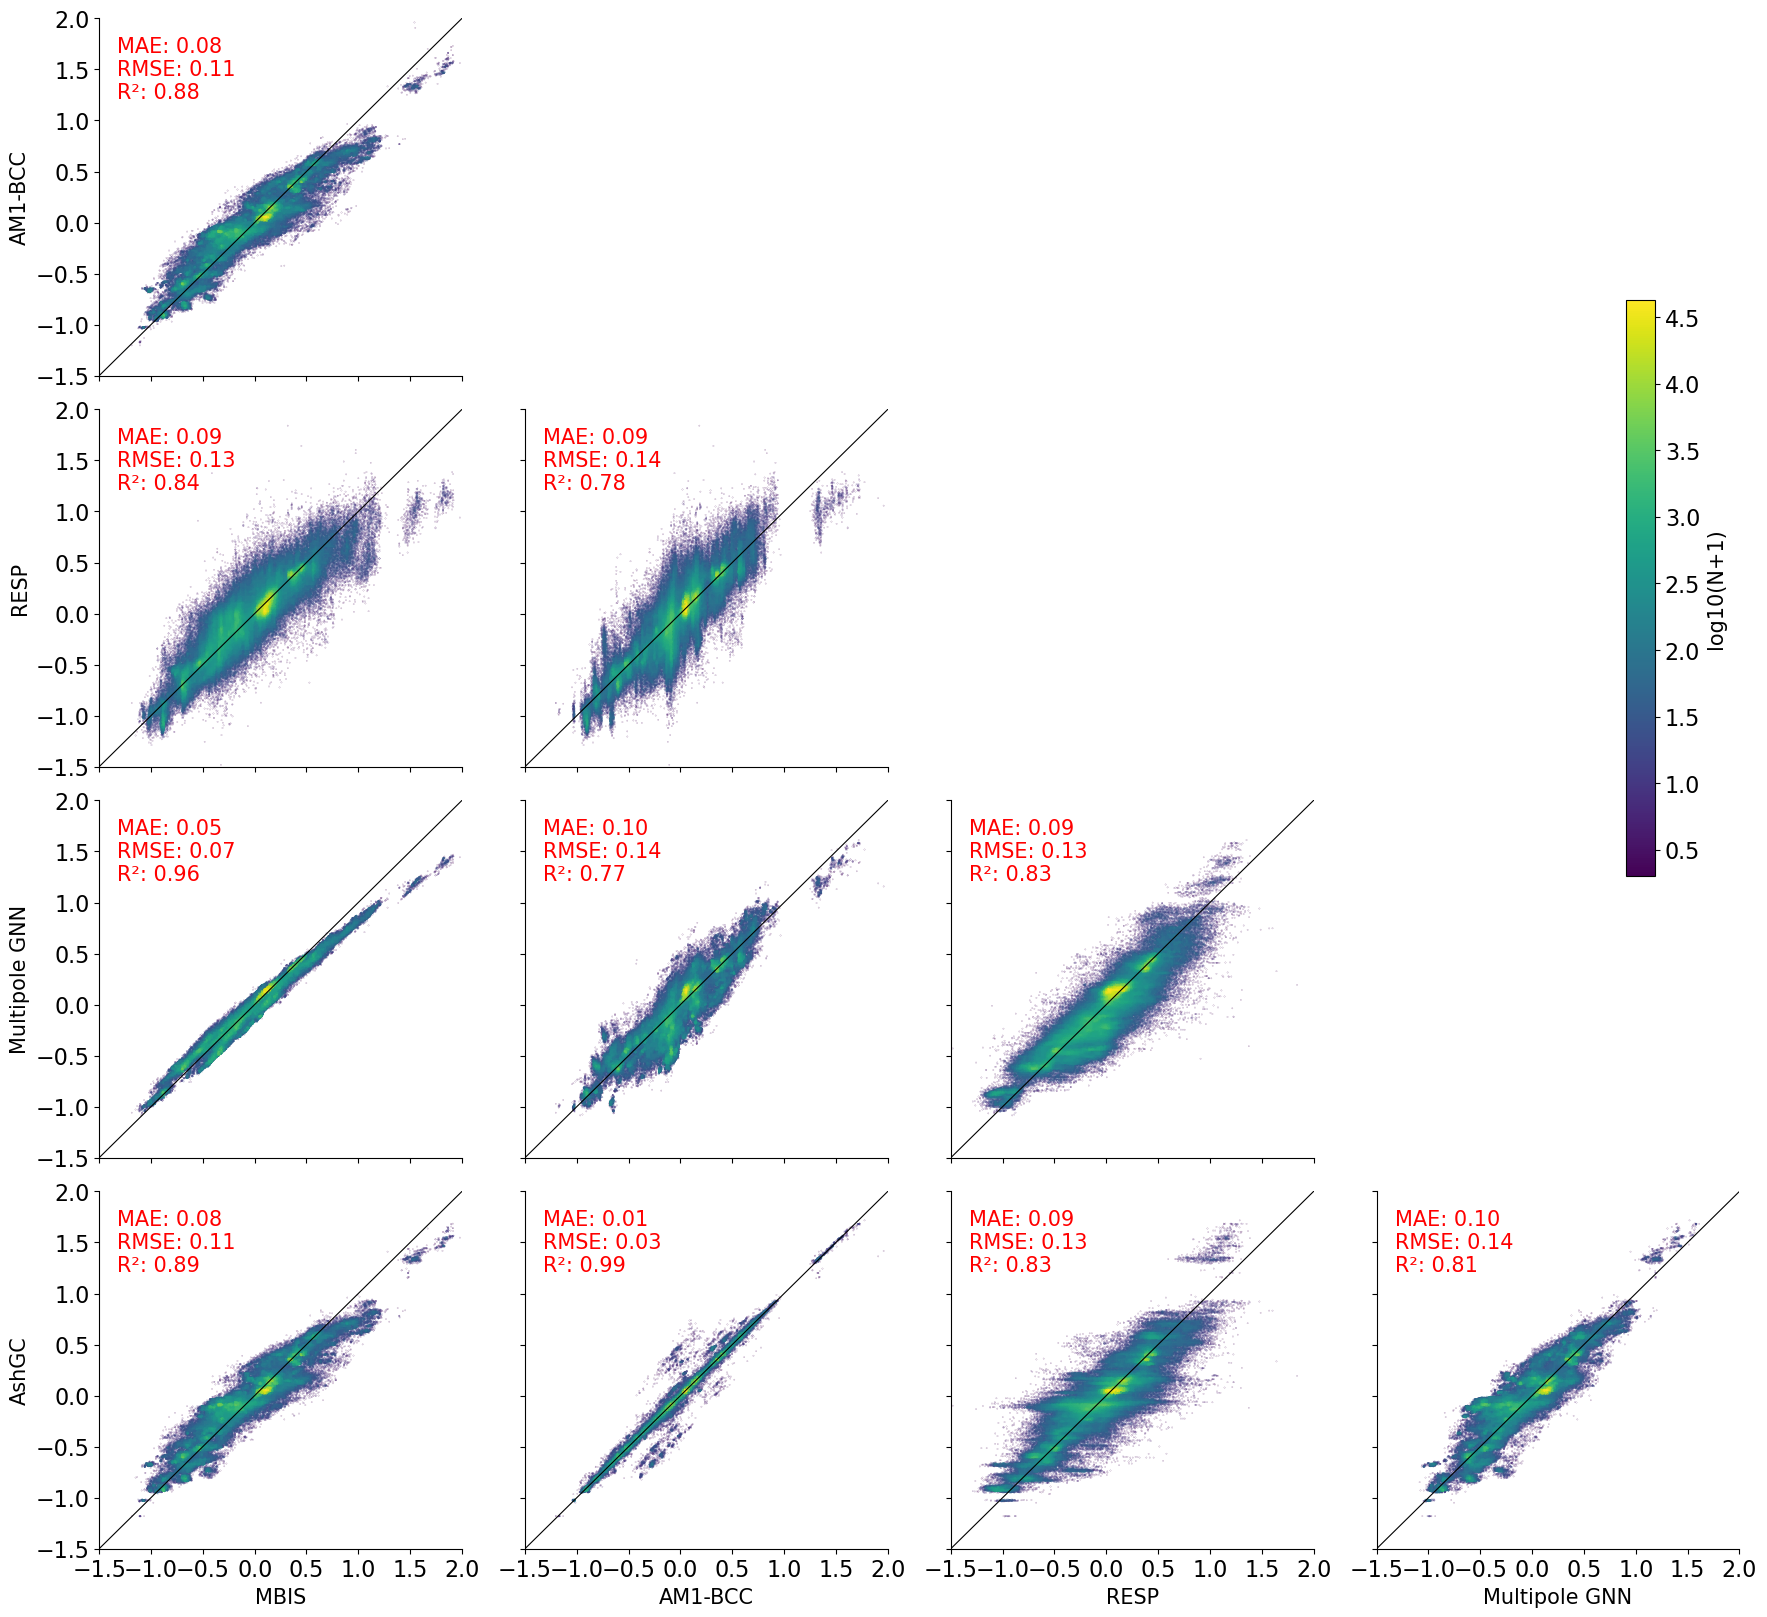

In [34]:
# 1. Set global figure font sizes, etc.
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# n_vars = len(df.columns)
desired_width = 4.5   # single column width in inches (ACS)

# Corner plot means n_vars - 1 subplots in the longest row
# n_subplots = n_vars - 1
height_each = 4.5
aspect = (desired_width /height_each)

mbis_charges_flat = np.concatenate(df['mbis_charges'].values)
am1bcc_charges_flat = np.concatenate(df['am1bcc_charges'].values)
resp_charges_flat = np.concatenate(df['resp_charges'].values)
espaloma_charges_flat = np.concatenate(df['espaloma_charges'].values)
multipole_gnn_charges_flat = np.concatenate(df['riniker_monopoles'].values)
ash_charges_flat = np.concatenate(df['nagl_ash_charges'].values)
elf10_charges_flat = np.concatenate(df['elf10_charges'].values)

charges_df = pd.DataFrame({
    "MBIS": mbis_charges_flat,
    "AM1-BCC": am1bcc_charges_flat,
    "RESP": resp_charges_flat,
    # "EspalomaCharge": espaloma_charges_flat,
    "Multipole GNN": multipole_gnn_charges_flat,
    "AshGC": ash_charges_flat,
    # "ELF10": elf10_charges_flat
})

g = sns.PairGrid(charges_df,
                 height=height_each,
                 aspect=aspect,
                 diag_sharey=False,
                 corner=True)

# Plot the density as a 2D histogram instead of scatter
g.map_offdiag(density_scatter, bins=150, range=[(-1.5, 2), (-1.5, 2)], s=0.01)

# Add equality line y=x
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            ax.plot([-1.5, 2], [-1.5, 2], color='black', linestyle='-', linewidth=0.8)

# Annotate metrics
g.map_offdiag(annotate_metrics)

# Remove diagonal plots
for ax in np.diag(g.axes):
    ax.set_visible(False)

# Set axis limits
g.set(xlim=(-1.5,2), ylim=(-1.5, 2))

# Label the axes on the outer edges
n = len(charges_df.columns)
for i, ax_row in enumerate(g.axes):
    for j, ax in enumerate(ax_row):
        if ax is not None:
            if i == n - 1:
                ax.set_xlabel(charges_df.columns[j], fontsize=15)
            if j == 0:
                ax.set_ylabel(charges_df.columns[i], fontsize=15)

g.fig.subplots_adjust(top=0.9)

ticks = np.arange(-1.5, 2.1, 0.5)  # or whatever interval you prefer
g.set(xticks=ticks, yticks=ticks)

# g.fig.suptitle('Pairwise Comparison of Charge Models (log-density)', fontsize=16)

scatter = None
for ax_row in g.axes:
    for ax in ax_row:
        if ax and len(ax.collections) > 0:
            # The scatter plot is a PathCollection in ax.collections
            # We set norm and cmap on the scatter itself, so let's find it
            candidate = [c for c in ax.collections if hasattr(c, 'norm')]
            if candidate:
                scatter = candidate[0]
                break
    if scatter is not None:
        break
# Filter out None axes
valid_axes = [ax for ax_row in g.axes for ax in ax_row if ax is not None]

if scatter is not None:
    from matplotlib.cm import ScalarMappable
    sm = ScalarMappable(norm=scatter.norm, cmap=scatter.cmap)
    sm.set_array([])
    g.fig.subplots_adjust(right=0.85)  # Move figure edge closer, thus bringing the colorbar in

    cbar = g.fig.colorbar(sm, ax=valid_axes, shrink=0.3,pad=-0.3)
    cbar.set_label('log10(N+1)', fontsize=15)


plt.savefig('pairwise_partial_charges_density_2.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/8_/xls29m695yl7qglq81r94h7w0000gr/T/ipykernel_9256/2929271761.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


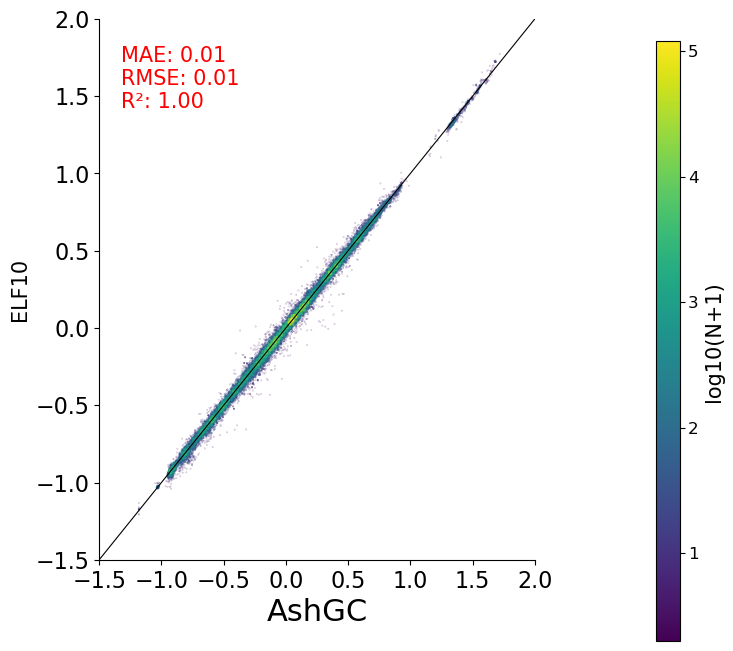

In [33]:
small_df = pd.DataFrame({
    "AshGC": ash_charges_flat,
    "ELF10": elf10_charges_flat
})
g = sns.PairGrid(small_df,
                 height=6,
                 aspect=1,
                 diag_sharey=False,
                 corner=True)

# Plot the density as a 2D histogram instead of scatter
g.map_offdiag(density_scatter, bins=150, range=[(-1.5, 2), (-1.5, 2)], s=0.01)

# Add equality line y=x
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            ax.plot([-1.5, 2], [-1.5, 2], color='black', linestyle='-', linewidth=0.8)

# Annotate metrics
g.map_offdiag(annotate_metrics)

# Remove diagonal plots
for ax in np.diag(g.axes):
    ax.set_visible(False)

# Set axis limits
g.set(xlim=(-1.5,2), ylim=(-1.5, 2))

# Label the axes on the outer edges
n = len(charges_df.columns)
for i, ax_row in enumerate(g.axes):
    for j, ax in enumerate(ax_row):
        if ax is not None:
            if i == n - 1:
                ax.set_xlabel(small_df.columns[j], fontsize=15)
            if j == 0:
                ax.set_ylabel(small_df.columns[i], fontsize=15)

g.fig.subplots_adjust(top=0.88,right=0.87, wspace=0.05, hspace=0.05)

ticks = np.arange(-1.5, 2.1, 0.5)  # or whatever interval you prefer
g.set(xticks=ticks, yticks=ticks)
g.tight_layout(rect=[0, 0, 0.88, 1])  # limits the area used by PairGrid

# g.fig.suptitle('Pairwise Comparison of Charge Models (log-density)', fontsize=16)

scatter = None
for ax_row in g.axes:
    for ax in ax_row:
        if ax and len(ax.collections) > 0:
            # The scatter plot is a PathCollection in ax.collections
            # We set norm and cmap on the scatter itself, so let's find it
            candidate = [c for c in ax.collections if hasattr(c, 'norm')]
            if candidate:
                scatter = candidate[0]
                break
    if scatter is not None:
        break
# Filter out None axes
valid_axes = [ax for ax_row in g.axes for ax in ax_row if ax is not None]

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(norm=scatter.norm, cmap=scatter.cmap)
sm.set_array([])

g.fig.subplots_adjust(right=0.6)    # leave room for our custom cax
g.fig.canvas.draw()                  # make sure axes positions are up to date

cbar_ax = g.fig.add_axes([0.55, 0, 0.02, 0.5])

cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('log10(N+1)', fontsize=15)

cbar.ax.tick_params(labelsize=12, pad=2)

g.tight_layout(rect=[0, 0, 0.85, 1])  
plt.savefig('ASHGCvsELF10.png', dpi=400, bbox_inches ='tight')

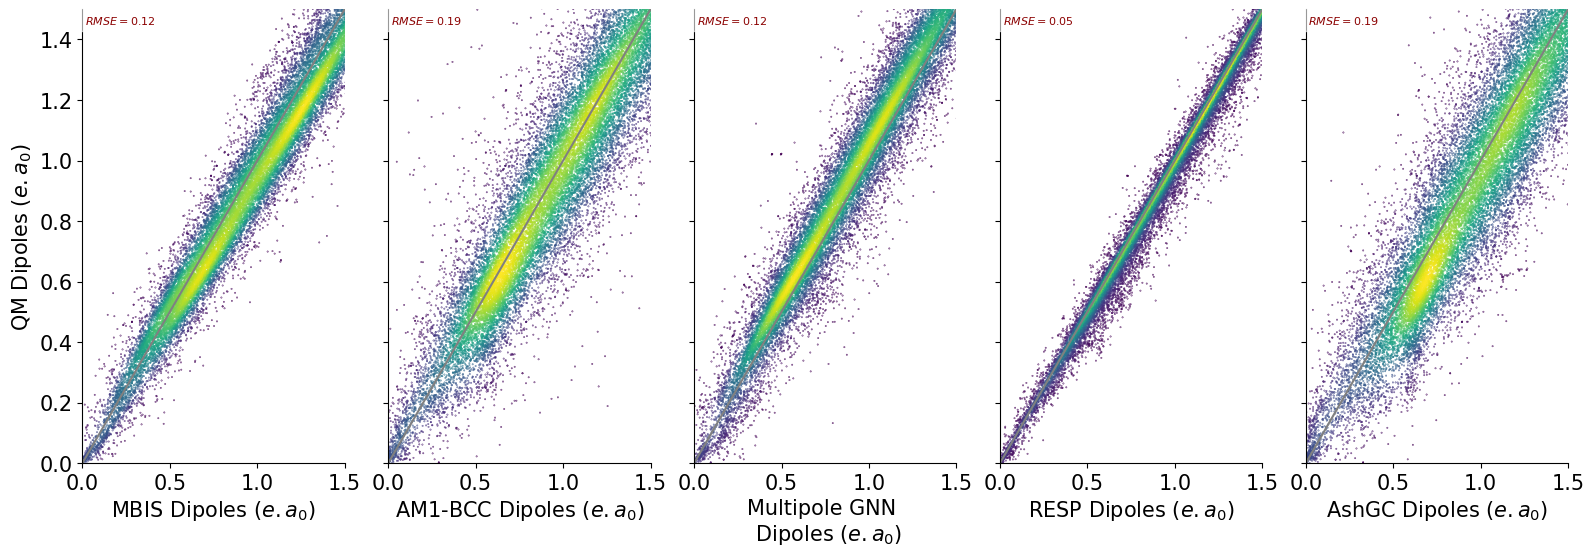

In [37]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 15          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.labelsize'] =15
mpl.rcParams['ytick.labelsize'] = 15

width = 3.25  # inches (or 7.0)
height = 5.5
aspect = width / height

# Define the columns you want to compare against QM_HF_Dipoles
# compare_columns = [['mbis_dipoles', 'am1bcc_dipole', 'espaloma_dipole', 'riniker_dipoles', 'resp_dipole','nagl_ash_dipole','elf10_dipole']]

mbis_dipoles = df['mbis_dipoles'].values
am1bcc_dipoles = df['am1bcc_dipole'].values
resp_dipoles = df['resp_dipole'].values
espaloma_dipoles = df['espaloma_dipole'].values
multipole_gnn_dipoles = df['riniker_dipoles'].values
ash_dipoles = df['nagl_ash_dipole'].values
elf10_dipoles = df['elf10_dipole'].values
qm_dipoles = df['qm_dipoles'].values

dipoles_df = pd.DataFrame({
    "qm_dipoles": qm_dipoles,
    "mbis_dipoles": mbis_dipoles,
    "am1bcc_dipole": am1bcc_dipoles,
    "resp_dipole": resp_dipoles,
    # "espaloma_dipole": espaloma_dipoles,
    "riniker_dipoles": multipole_gnn_dipoles,
    "nagl_ash_dipole": ash_dipoles,
    # "elf10_dipole": elf10_dipoles
})

compare_columns = [
    "mbis_dipoles",
    "am1bcc_dipole",
    # "espaloma_dipole",
    "riniker_dipoles",
    "resp_dipole",
    "nagl_ash_dipole",
    # "elf10_dipole"
]

# Initialize a PairGrid with col_wrap set to 3 for 3 columns per row
grid = sb.PairGrid(
    dipoles_df, 
    x_vars=compare_columns, 
    y_vars=['qm_dipoles'], 
    height=height, 
    aspect=aspect
)

# Map the plots to the grid
grid = grid.map(density_scatter_plot, s=0.1)
grid = grid.map_offdiag(equalityline, color='gray', ls='-')
grid = grid.map_offdiag(m)
grid.map_diag(sb.kdeplot, color='gray')

# Set axis limits
grid.set(xlim=(0, 1.5), ylim=(0, 1.5))

label_dict = {
    "am1bcc_dipole": "AM1-BCC Dipoles ($e.a_{{0}}$)",
    "riniker_dipoles": "Multipole GNN \n Dipoles ($e.a_{{0}}$)",
    "resp_dipole": "RESP Dipoles ($e.a_{{0}}$)",
    "mbis_dipoles": "MBIS Dipoles ($e.a_{{0}}$)",
    "qm_dipoles": "QM Dipoles ($e.a_{{0}}$)",
    # "espaloma_dipole": "EspalomaCharge \n Dipoles ($e.a_{{0}}$)",
    "nagl_ash_dipole": "AshGC Dipoles ($e.a_{{0}}$)",
    # "elf10_dipole": "ELF10 Dipoles ($e.a_{{0}}$)"
}
    
# Manually set x-axis and y-axis labels
for i, ax in enumerate(grid.axes.flat):
    if i % len(compare_columns) == 0:  # y-axis label
        ax.set_ylabel(label_dict['qm_dipoles'], fontsize=15)
    if i < len(compare_columns):  # x-axis label
        ax.set_xlabel(label_dict[compare_columns[i % len(compare_columns)]], fontsize=15)

# Save and display the plot
plt.savefig('comparison_of_dipoles.png', bbox_inches= 'tight', dpi=300)
plt.show()


In [ ]:
df.iloc[0]

mbis_charges         [-0.307478181466797, -0.32475236546718506, 0.0...
am1bcc_charges       [-0.1269, -0.1269, -0.111, -0.0814, 0.1528, -0...
espaloma_charges     [-0.17321058894906724, -0.17321058894906724, -...
riniker_monopoles    [-0.3678119480609894, -0.37190431356430054, 0....
resp_charges         [-0.3026, -0.3026, 0.1671, -0.0841, 0.0157, -0...
qm_dipoles                                                    0.463489
mbis_dipoles                                                  0.328383
am1bcc_dipole                                                 0.411711
espaloma_dipole                                               1.121593
riniker_dipoles                                               0.320236
resp_dipole                                                   0.474776
am1bcc_esp_rms                                                1.711427
espaloma_esp_rms                                              4.318221
resp_esp_rms                                                   1.33664
mbis_e

In [ ]:
from openff.nagl import GNNModel
nagl_model = GNNModel.load("/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.3.pt")


In [ ]:
nagl_model.compute_properties(Molecule.from_smiles('CCO'))

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


{'am1bcc_charges': array([-0.09629,  0.13245, -0.60293,  0.04465,  0.04465,  0.04465,
         0.01728,  0.01728,  0.39826], dtype=float32)}

In [ ]:
nagl_model.compute_properties(Molecule.from_smiles('CCO'))['am1bcc_charges']

array([-0.09629,  0.13245, -0.60293,  0.04465,  0.04465,  0.04465,
        0.01728,  0.01728,  0.39826], dtype=float32)

In [ ]:
dir_path = openff.nagl_models.get_nagl_model_dirs_paths()[0]
nagl_model = GNNModel.load(str(dir_path) + "/openff-gnn-am1bcc-0.1.0-rc.3.pt")

NameError: name 'openff' is not defined

In [ ]:
dir_path = openff.nagl_models.get_nagl_model_dirs_paths()[0]


'/Users/k2584788/.local/share/mamba/envs/charge_model_env/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc'

['nagl_ashe', 'am1bcc', 'mbis', 'riniker', 'resp']


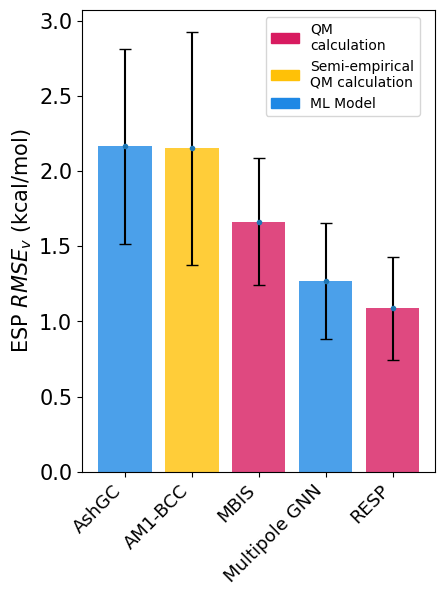

In [39]:
# Define the columns to compare
compare_columns = [
    'am1bcc_esp_rms',
    # 'espaloma_esp_rms',
    'riniker_esp_rms',
    'mbis_esp_rms', 
    'resp_esp_rms',
    'nagl_ash_esp_rmse',
    # 'elf10_esp_rmse'
]

ML_model_color = "#1E88E5"
QM_color = "#D81B60"
semi_empirical_color  = "#FFC107"

# Assign colors based on the requirements for each method
color_map = {
    'am1bcc_esp_rms': semi_empirical_color,   # Semi-empirical QM calculation
    'espaloma_esp_rms': ML_model_color,  # No QM calculation required
    'riniker_esp_rms': ML_model_color,   # No QM calculation required
    'mbis_esp_rms': QM_color,       # QM calculation required
    'resp_esp_rms': QM_color,        # QM calculation required
    'nagl_ash_esp_rmse' : ML_model_color,
    # 'elf10_esp_rmse': semi_empirical_color,
}

# Calculate mean and standard deviation for the columns
mean_values = df[compare_columns].mean()
std_dev_values = df[compare_columns].std()

# Create a DataFrame for easy sorting and plotting
mean_values_df = pd.DataFrame({
    'mean': mean_values,
    'std_dev': std_dev_values,
    'color': [color_map[col] for col in compare_columns]  # Map colors to methods
}).sort_values(by='mean', ascending=False)

# Remove '_esp_rms' from the xtick labels
xtick_labels = [label.replace('_esp_rms', '') for label in mean_values_df.index]
print(xtick_labels)
width = 4.56

# Plot the bar chart with error bars
plt.figure(figsize=(width, 6))  # Adjust figure size as needed
plt.bar(
    x=xtick_labels,
    height=mean_values_df['mean'],
    color=mean_values_df['color'],  # Use the assigned colors
    alpha=0.8,
    label='Mean ESP RMSE'
)
plt.errorbar(
    x=xtick_labels,
    y=mean_values_df['mean'],
    yerr=mean_values_df['std_dev'],
    fmt=".", ecolor='black', capsize=4
)

label_mapping = {
    "am1bcc_esp_rms": "AM1-BCC",
    "espaloma_esp_rms": "EspalomaCharge",
    "riniker_esp_rms": "Multipole GNN",
    "mbis_esp_rms": "MBIS",
    "resp_esp_rms": "RESP",
    "nagl_ash_esp_rmse": "AshGC",
    # "elf10_esp_rmse":"ELF10"
}
new_labels = [label_mapping[col] for col in mean_values_df.index]



# Add labels and formatting
plt.xticks(ticks=range(len(new_labels)), labels=new_labels,rotation=45, ha='right', fontsize=13)
plt.ylabel('ESP $RMSE_{v}$ (kcal/mol)', fontsize=15)
# plt.xlabel('Methods', fontsize=15)
# plt.title('Comparison of ESP RMSE Values Across Methods', fontsize=14)

# Add a legend for context
red_patch = mpatches.Patch(color=QM_color,
    label='QM\ncalculation')
green_patch = mpatches.Patch(color=semi_empirical_color,
    label='Semi-empirical\nQM calculation')
blue_patch = mpatches.Patch(color=ML_model_color,
    label='ML Model')

plt.legend(
    handles=[red_patch, green_patch, blue_patch],
    bbox_to_anchor=(0.5, 1),  
    loc='upper left',           
    fontsize=10
)
# Save the figure or display it
plt.savefig('esp_comparison.png', dpi=800, bbox_inches='tight')
plt.show()
